# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4 - Алгоритмы кластеризации


###### <hr\>
**Общая информация**

**Срок сдачи:** 6 мая 2019, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 6 мая, -4 балла после 06:00 13 мая, -6 баллов после 06:00 20 мая -8 баллов  после 06:00 27 мая


Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

**Из чего состоит задание:**

###### Теоретические вопросы (2 балла)

###### Реализация алгоритма кластеризации (5 баллов)

###### Боевое применение (3 балла)




**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw4.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст. В противном случае -1 балл

In [1]:
import time
import pandas as pd
import pylab as pl
import numpy as np
import scipy.spatial as ss
import sklearn.cluster as sc
import sklearn.manifold as sm
import sklearn.datasets as ds
import sklearn.metrics as smt
from scipy.cluster import hierarchy
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Теоретическое введение


Основная задача кластерного анализа — разбиение исходного набора объектов на группы (кластеры) таким образом, чтобы объекты в группе были похожи друг на друга, а объекты из разных групп - отличались. 

В этой работе мы будем реализовывать агломеративную кластеризацию. 

## Агломеративная кластеризация

Иерархические алгоритмы кластеризации строят на выборке систему вложенных разбиений.  Наиболее часто испоьзуемые иерархические алгоритмы - агломеративные алгоритмы, которые строят ирархию по восходящей, то есть от момента, когда все элементы являются отдельными кластерами, до того момента, пока вся выборка не станет одним кластером.

Сам алгоритм описать можно примерно так:

* начинаем с ситуации, когда каждый объект - отдельный кластер
* на каждом шаге совмещаем два наиболее близких кластера
* останавливаемся, когда получаем требуемое количество или единственный кластер


В данной работе Вам предлагается реализовать три варианта расстояний между кластерами, по которым Вы определяете пару для слияния: 
* Single linkage
$$ d_{min}(C_i, C_j) = \min_{\mathbf{x} \in C_i, \mathbf{x}' \in C_j} \|\mathbf{x} -\mathbf{x}' \| $$

* Complete linkage
$$ d_{max}(C_i, C_j) = \max_{\mathbf{x} \in C_i, \mathbf{x}' \in C_j} \|\mathbf{x} -\mathbf{x}' \| $$

* Average linkage
$$ d_{avg}(C_i, C_j) = \frac{1}{n_i n_j}\sum_{\mathbf{x} \in C_i}\sum_{\mathbf{x}' \in C_j} \|\mathbf{x} -\mathbf{x}' \| $$

Как считать расстояние $\|\mathbf{x} -\mathbf{x}' \|$ между объектами Вы должны выбрать сами.  Вы должны четко понимать, что выбор расстояния между объектами - самое важное в такого рода алгоритмах. Передавайте название расстояния в конструктор класса, а потом, в зависимости от названия, применяете ту или иную функцию для подсчета расстояния. 



Для того, чтобы на втором этапе нам не пересчитывать заново расстояния между всеми парами кластеров, можно использовать Формулы Ланса-Вильямса, которые позволяют посчитать расстояние между кластерами после объединения, используя только расстояния между кластерами до объедения.  Таким образом, достаточно будет посчитать расстояния только между всеми одноэлементными кластерами (первый этап), а затем пересчитывать расстояния при их объединении через 
формулы Ланса-Вильямса. 

Общая  формула выглядит так:
$$ d(C_i \cup C_j, C_k) = a_i \cdot d(C_i, C_k) + a_j \cdot d(C_j, C_k) + b \cdot d(C_i, C_j) + c \cdot |d(C_i, C_k) - d(C_j, C_k)|$$

Можно показать, что все относительно разумные кластерные расстояния можно описать данной формулой. 

Для интересущих нас linkage:

* single-linkage       $a_i = \frac{1}{2}, a_j =  \frac{1}{2}, b = 0, c =  - \frac{1}{2} $

* complete-linkage     $a_i = \frac{1}{2}, a_j =  \frac{1}{2}, b = 0, c =   \frac{1}{2} $

* average-linkage       $a_i = \frac{|C_i|}{|C_i \cup C_j|}, a_j =  \frac{|C_j|}{|C_i \cup C_j|}, b = 0, c = 0 $



# Теоретические вопросы (2 балла)
В этой части Вам будут предложены теоретичские вопросы и задачи по теме. Вы, конечно, можете списать их у своего товарища или найти решение в интернете, но учтите, что они обязательно войдут в теоретический коллоквиум. Лучше разобраться в теме сейчас и успешно ответить на коллоквиуме, чем списать, не разобравшись в материале, и быть терзаемым совестью. 


Формулы надо оформлять в формате **LaTeX**.

Задача 1. Сходимость kmeans.

Метод kmeans является частным случаем EM алгоритма и наиболее простым в обосновании сходимости. Докажите, что kmeans всегда сходится, и итераций не будет превышать $k^N$, где $k$ $-$ число кластеров, $N$ $-$ число объектов

Подсказка: Вам стоит рассмотреть функционал, который минимизирует алгоритм, и подумать, как он изменяется на E шаге и на M шаге.



***Ваше решение здесь***

Введем функционал качества:
$$ E(C) = \sum_{n=1}^N\sum_{k=1}^Kr_{n,k}||x_n-\mu_k||^2 $$
Объект может принадлежать единственному кластеру (следует из постановки задачи кластеризации), значит, на шаге E (пересчете $r_{n,k}$) при фиксированном $n$ будет существовать единственное $k$, для которого $r_{n,k} = 1$ и которому соответствует ближайший кластер к объекту $n$, остальные же обратятся в $0$, то есть сумма, приведенная выше, на шаге Е может быть переписана в виде:

$$\sum_{n=1}^N\min_k ||x_n - \mu_k||^2 = \min_{k=\overline{1,K}}\sum_{n=1}^N||x_n - \mu_k||^2$$

На шаге M функция рассматривается как многочлен второй степени. В силу независимости кластеров задача разбивается на k подзадач, в которых необходимо найти оптимальное $\mu_k$. Взяв производную от $\sum_{t=1}^T||x_t - \mu_k||^2$, где $T$ - число элементов в кластере, придем к равенству:

$$ \mu_k = \frac{\sum_{t=1}^Tx_t}{T}$$

Итак, на каждом из шагов E и M функция $E(C)$ является невозрастающей, она ограничена снизу, значит, по теореме о сходимости монотонной ограниченной последовательности и из определения предела функции $E(C)$ и алгоритм вместе с ней сходится.

Число итераций не будет превышать числа возможных распределений $N$ объектов по $k$ кластерам, которых в точности $k^N$. Это следует из того, что на каждом шаге мы находим и запоминаем наиболее оптимальные из уже просмотренных параметры, которые описывают единственное распределение.

Задача 2. Сходимость EM.

Разобравшись со сходимостью kmeans, можно догадаться и до ответа про EM алгоритм.

При каком условии на правдоподобие системы EM алгоритм будет  сходиться?



***Ваше решение здесь***

Он будет сходиться, если выполнены условия регулярности и если зависимость событий, вероятности которых входят в произведение, будет мала, то есть если будет выполняться изначально принятое соглашение о независимости событий.

EM алгоритм для функции правдоподобия работает аналогично k-means: на шаге E максимизируется нижняя оценка L, на шаге M берется наибольшее значение значение функции для фиксированного мнимого параметра, то есть L не убывает и является ограниченной сверху нулем, следовательно, L также сходится.

Задача 3. Формулы Ланса-Вильямса.

Формулы Ланса-Вильямса крайне удобны для быстрого пересчта расстояний в агломеративной кластеризации. Давайте докажем  формулы для single и complete linkage. 

Докажите, что:

$d_{\min}(U \cup V, S) = \frac{1}{2} d_{\min}(U, S) + \frac{1}{2} d_{\min}(V, S)  - \frac{1}{2} | d_{\min}(U, S) - d_{\min}(V, S) |  $


$d_{\max}(U \cup V, S) = \frac{1}{2} d_{\max}(U, S) + \frac{1}{2} d_{\max}(V, S)  + \frac{1}{2} | d_{\max}(U, S) - d_{\max}(V, S) |  $




***Ваше решение здесь***

В силу независимости множеств $U$ и $V$ имеют место следующие формулы:

$d_{\min}(U \cup V, S) = \min{(d_{\min}(U, S),\ d_{\min}(V, S))}  $

$d_{\max}(U \cup V, S) = \max{(d_{\max}(U, S),\ d_{\max}(V, S))}  $

Они аналогичны данным.

# Реализация алгоритма кластеризации  (5 баллов)

Алгоритм кластеризации должен удовлетворять следующему интерфейсу. Конструктор принимает набор параметров, необходимых для работы алгоритма кластеризации. Метод `fit` подсчитывает параметры модели и возвращает `self`. Метод `predict` возвращает вектор с индексами кластеров для поданных в него объектов `x`. 

In [2]:
from sklearn.base import BaseEstimator, ClusterMixin


class Clustering(BaseEstimator, ClusterMixin):    
    
    def __init__(self, metric='euclidean',
                 linkage='single', n_clusters=2, **kwargs):
        self.metric = metric
        if metric == 'euclidean':
            self.distance = self.__euclidean
        if metric == 'manhattan':
            self.distance = self.__manhattan
        if metric == 'cosine':
            self.distance = self.__cosine
        self.indent = n_clusters
        self.linkage = linkage
        self.dendrogram = np.array([])
    
    def __euclidean(self, a, b):
        c = a - b
        return np.sqrt(np.dot(c, c.T))

    def __cosine(self, a, b):
        a = np.array(a)
        b = np.array(b)
        t = np.dot(a, b.T)
        p = sqrt((a ** 2).sum()) * sqrt((b ** 2).sum())
        if t / p > 1:
            return 0
        return np.arccos(t / p)


    def __manhattan(self, a, b):
        c = a - b
        return np.sum(np.absolute(c))  
    
    def __linkage(self, x, mask1, mask2):
        coef = np.zeros(3)
        if self.linkage == 'single':
            coef[:] = 0.5, 0.5, -0.5
        if self.linkage == 'complete':
            coef[:] = 0.5, 0.5, 0.5
        if self.linkage == 'average':
            c1_quantity = np.sum(mask1)
            c2_quantity = np.sum(mask2)
            all_quantity = c1_quantity + c2_quantity
            coef[:2] = c1_quantity, c2_quantity
            coef /= all_quantity
        for k in range(self.size):
            d_i_k = x[k][mask1][0]
            d_j_k = x[k][mask2][0]
            d_ij_k = coef[0] * d_i_k + coef[1] * d_j_k
            d_ij_k += coef[2] * np.absolute(d_i_k - d_j_k)
            x[k, mask1 + mask2] = x[mask1 + mask2, k] = d_ij_k
            if mask1[k] or mask2[k]:
                x[k, mask1] = x[mask1, k] = x[k, mask2] = x[mask2, k] = 0
        return x            

    def __find_min(self, x, clusters):
        min_info = np.array([0, 0, -1, 0], dtype='float64')
        for i in range(self.size):
            for j in range(i + 1, self.size):            
                if (min_info[2] > x[i][j] or min_info[2] == -1) \
                and clusters[i] != clusters[j]:
                    min_info[:3] = i, j, x[i][j]
        return min_info

    def __fit(self, x):
        size = self.size
        distances = np.zeros((size, size))
        clusters = np.zeros((size, size), dtype='int64')
        clusters[0] = np.arange(size)
        for i in range(size):
            for j in range(i + 1, size):
                distances[i][j] = distances[j][i] = self.distance(x[i],
                                                                  x[j])
        for step in range(1, size):
            min_info = self.__find_min(distances, clusters[step - 1])
            i = min_info[0]
            j = min_info[1]
            cl1_mask = clusters[step - 1] == clusters[step - 1][int(i)]
            cl2_mask = clusters[step - 1] == clusters[step - 1][int(j)]
            min_info[0] = clusters[step - 1][int(i)]
            min_info[1] = clusters[step - 1][int(j)]
            min_info[3] = np.sum(cl1_mask) + np.sum(cl2_mask)
            clusters[step] = np.copy(clusters[step - 1])
            clusters[step][cl1_mask + cl2_mask] = size + step - 1
            self.dendrogram = np.append(self.dendrogram, min_info)
            distances = self.__linkage(distances, cl1_mask, cl2_mask)
        self.dendrogram = self.dendrogram.reshape(-1, 4)
        self.clusters = clusters

    def fit_predict(self, x):
        self.size =  x.shape[0]
        self.__fit(x)
        return self.clusters[self.size - self.indent]

    def plot_dendrogram(self):
        fig = plt.figure()
        fig.set_figheight(10)
        fig.set_figwidth(20)
        hierarchy.dendrogram(self.dendrogram)


Сначала проверим реализованный алгоритм кластеризации на классическом наборе данных [Iris](http://www.wikiwand.com/en/Iris_flower_data_set). Загрузим данные (они включены в библиотеку sklearn) и посмотрим на то, как они выглядят в двух проекциях (для простоты используем 2 класса из 3).

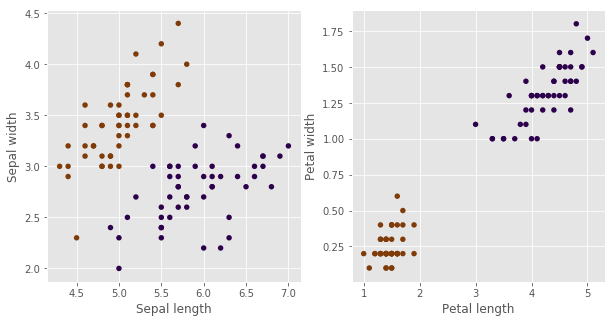

In [3]:
iris = ds.load_iris()
x_iris = iris.data[:100]
y_iris = iris.target[:100]

pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(1, 2, 2)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
pl.show()

Видно, что классы разделяются, поэтому можно надеяться, что наш алгоритм "найдет" кластеры, соответствующие исходным классам. Результат работы реализованного алгоритма кластеризации предлагается сравнить с эталонной кластеризацией. Для этого предлагается изучить метрику ([adjusted rand score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html)). В случае если значение этой метрики отличается от 1, предлагается поработать над улучшением реализации своего алгоритма.

In [4]:
# Давайте проверим, как справляются sklearn реализации
sklearn_aggl = AgglomerativeClustering(n_clusters=2)
aggl_t0 = time.time()
aggl_pred = sklearn_aggl.fit_predict(x_iris)
aggl_diff = time.time() - aggl_t0
aggl_score = smt.adjusted_rand_score(y_iris, aggl_pred)
print (" Sklearn AGGL score {}. Sklearn AGGL time {}".format(aggl_score, aggl_diff))

 Sklearn AGGL score 1.0. Sklearn AGGL time 0.0009980201721191406


In [5]:
# Здесь предскажем кластера, посчитаем метрику кластеризации и время работы, сравним со склерном
сustum_aggl = Clustering(n_clusters=2)
aggl_t0 = time.time()
aggl_pred = сustum_aggl.fit_predict(x_iris)
aggl_diff = time.time() - aggl_t0
aggl_score = smt.adjusted_rand_score(y_iris, aggl_pred)
print ("Our AGGL score {}. Our AGGL time {}".format(aggl_score, aggl_diff))

Our AGGL score 1.0. Our AGGL time 0.5322713851928711


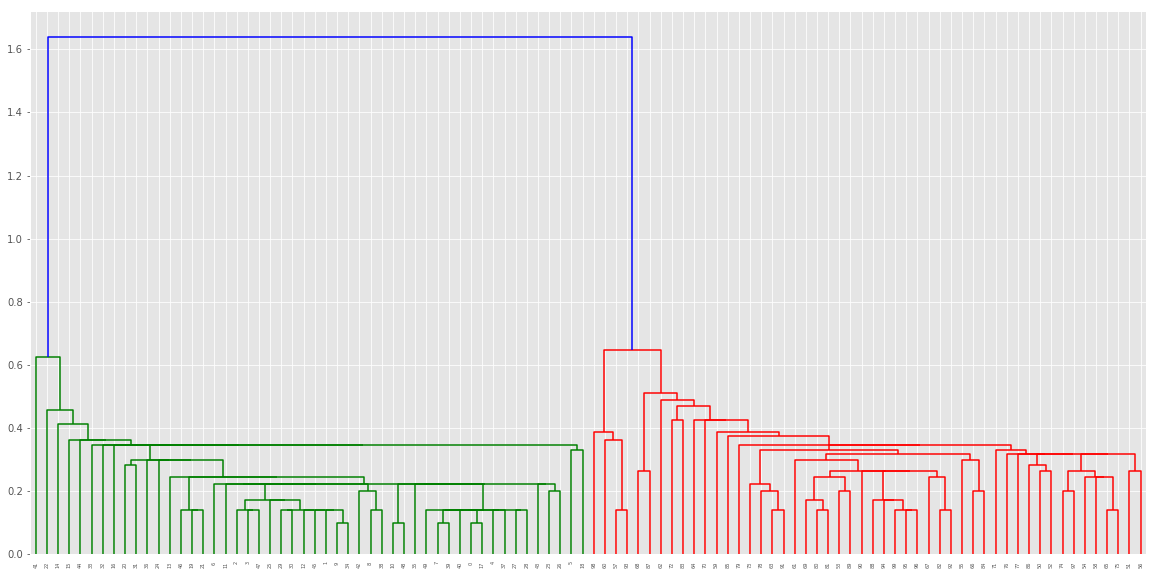

In [6]:
fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(20)
dendrogram = hierarchy.linkage(x_iris)
box = hierarchy.dendrogram(dendrogram)

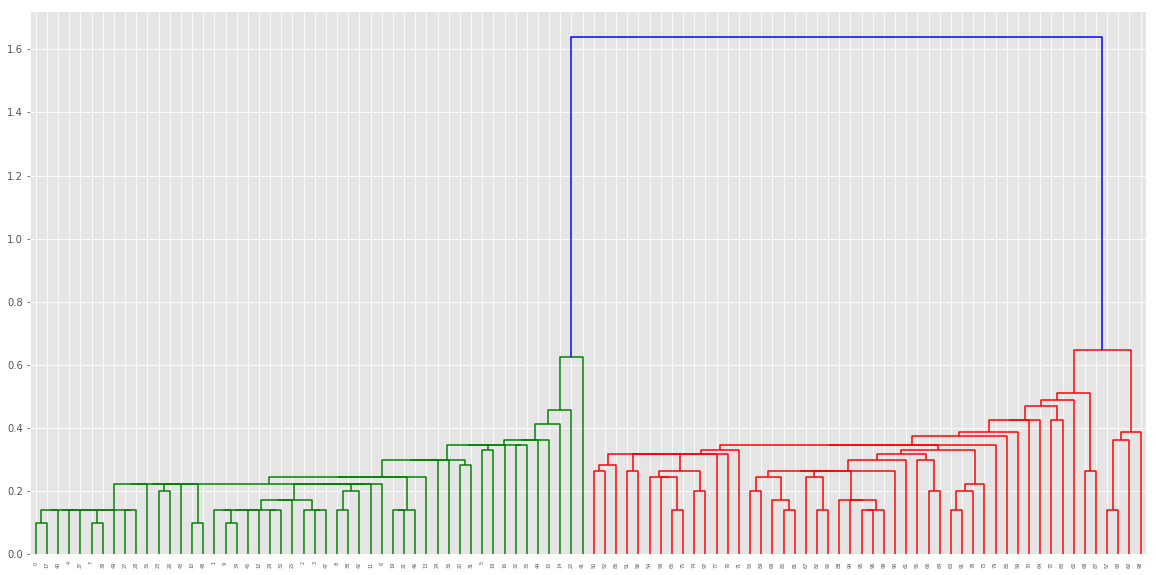

In [7]:
my_clf = Clustering(n_clusters=2)
my_clf.fit_predict(x_iris)
my_clf.plot_dendrogram()

# Боевое применение (3  балла)


Алгоритмы кластеризации прекрасны тем, что они позволяют быстро понять, как устроены наши данные. Давайте применим Ваш алгоритм для нашего конкурса!

Будем рассматривать каждую группу независимо от других групп. На каждой группе применим наш алгоритм и отрисуем денденограмму. По результатам кластерного анализа, Вам нужно ответить на следующие вопросы:

1) Можно ли по дендонаграмме (или по другим результатам кластеризации) сказать, где в группе аномалии? Каким образом?

***Ответ: можно, выбросы на графике не будут кучны и войдут в общий кластер лишь под конец работы алгоритма.***

2) Какое расстояние лучше использовать между заголовками страниц для кластеризации? Как еще учесть другую информацию о странице в расстоянии?

***Ответ: думаю, правильно выбранное расстояние особо не спасет группу, если она сплошь состоит из выбросов, а адекватную группу и обычные евклидова или манхеттенова метрики неплохо кластеризуют. Я привел лучшее рпзбиение, которое удалось получить, и разбиение рандомной группы, после подбора параметра f1_score удалось выжать только 0.5, что говорит о качестве данных в группе (и ничего не говорит о моих руках, нет).***

2) Какое качество f1_score Вы смогли получить на обучающем множестве методами кластеризации? (валидацию можете не делать, если таргет не используете)

***Ответ: очень разношерстные результаты получились, я привел ниже две наилучшим образом кластеризовавшиеся группы, но f1_score по остальным оставляют желать лучшего. Многое зависит от параметра n_ckusters, то есть от правильной обрезки дерева.***

4) Как можно результат кластеризации затем использовать для  финальной модели обучения с учителем?

***Ответ: можно отлавливать "троянских коней", вроде бы принадлежащих группе, но сильно похожих на выбросы и портящих обучение модели.***

Подсказка: самое важное - выбрать расстояние между заголовками. Самый простой вариант:  процент различных слов в двух заголовках. В семинаре мы рассматривали более сложный вариант, но Вы сможете придумать лучше. 

In [8]:
doc_to_title = {}
with open('docs_titles.tsv', encoding='utf-8-sig') as f:
    for num_line, line in enumerate(f):
        if num_line == 0:
            continue
        data = line.strip().split('\t', 1)
        doc_id = int(data[0])
        if len(data) == 1:
            title = ''
        else:
            title = data[1]
        doc_to_title[doc_id] = title
print(len(doc_to_title))

28026


In [9]:
train_data = pd.read_csv('train_groups.csv')
traingroups_titledata = {}
for i in range(len(train_data)):
    new_doc = train_data.iloc[i]
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    target = new_doc['target']
    title = doc_to_title[doc_id]
    if doc_group not in traingroups_titledata:
        traingroups_titledata[doc_group] = []
    traingroups_titledata[doc_group].append((doc_id, title, target))

Кластеризацию проводите в каждой группе отдельно, то есть изучайте, можно ли в группе  найти подкластер выбросов

Документы можно представлять например словами из тайтла

Главное подобрать хорошую функцию расстояния между документами

Удачи! Все получится!

Замечание: в кластеризации можно использовать все данные, то есть трейн + тест, чтобы находить больше закономерностей 

In [10]:
def make_dict(doc_id, doc_to_title, tokenizer):
    array = []
    for i in doc_id:
        sent = doc_to_title[i]
        array.append(' '.join(list(tokenizer(sent))))
    return array


def vectorize(doc_id, doc_to_title, vectorizer):
    tokenizer = vectorizer.build_tokenizer()
    dict_ = make_dict(df.doc_id, doc_to_title, tokenizer)
    vectorizer.fit(dict_)
    vectors = []
    for i in doc_id:
        sent = doc_to_title[i]
        vectors.append(sent)
    vectors = vectorizer.transform(vectors).todense()
    return vectors

In [11]:
vectorizer = TfidfVectorizer()

f1_score = 0.924731182795699


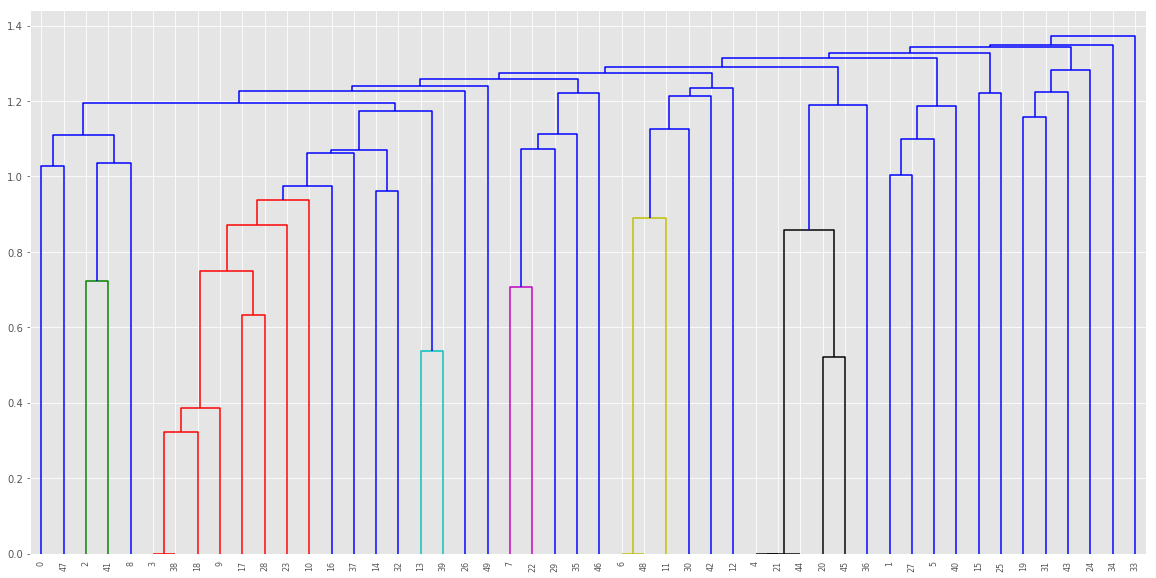

In [12]:
df = train_data[train_data.group_id == 128][['doc_id', 'target']]
X = vectorize(df.doc_id, doc_to_title, vectorizer)
myclf = Clustering(linkage='average', n_clusters=1)
cl = myclf.fit_predict(X)    
k = cl.size
for j in range(k):
    if cl[j] < k:
        cl[j] = 0
    else:
        cl[j] = 1
print('f1_score =', smt.f1_score(df.target, cl))
myclf.plot_dendrogram()

f1_score = 0.5


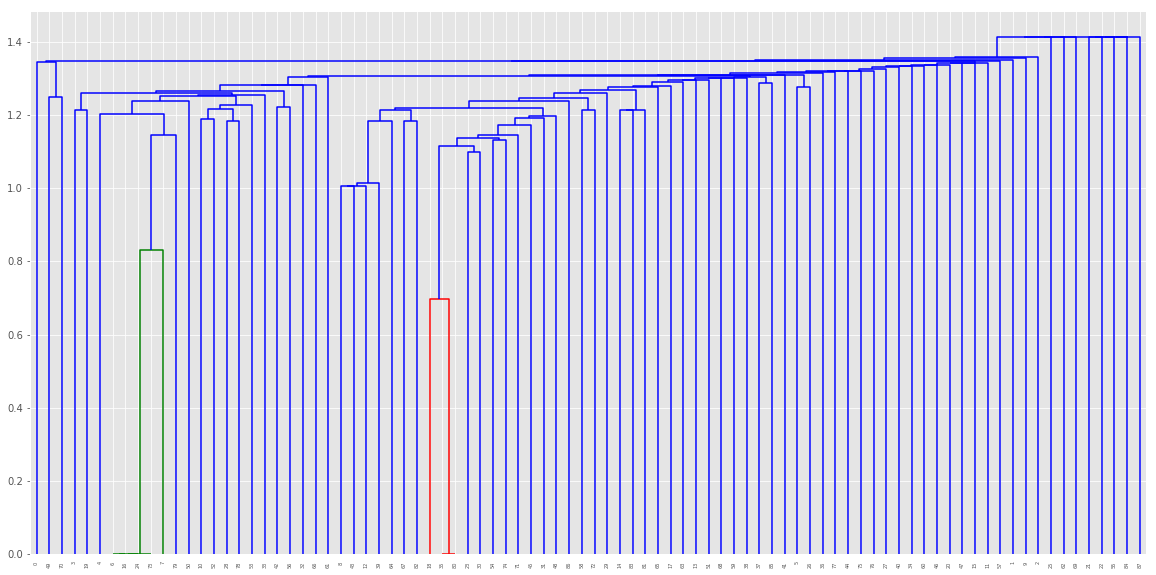

In [13]:
df = train_data[train_data.group_id == 4][['doc_id', 'target']]
X = vectorize(df.doc_id, doc_to_title, vectorizer)
my_clf = Clustering(linkage='single', n_clusters=74)
cl = my_clf.fit_predict(X)
k = cl.size
for j in range(k):
    if cl[j] < k:
        cl[j] = 0
    else:
        cl[j] = 1
print('f1_score =', smt.f1_score(df.target, cl))
my_clf.plot_dendrogram()

Если получилось найти выбросы с помощью кластеризации, то не забывайте использовать его в финальном решении. Помните - использование различных подходов к решению задачи всегда улучшает финального качество.

# Контрольные вопросы
Постарайтесь максимально развернуто и честно ответить на вопросы. Они охватывают тему алгоритмов кластеризации и скорее нужны преподавателям, чтобы понимать, что именно Вы усвоили плохо. Надеюсь, они подскажут, что именно в теме Вы не понимаете или наоборот порадают, что Вы все знаете ^_^

* Опишите, пожалуйста, для каких прикладных задач Вы бы стали использовать методы кластеризации?

***Ваше ответ здесь***

Для задач, в которых известны лишь признаки, описывающие объекты, и необходимо найти взаимосвязи и закономерности, существующие между ними. Например, кластеризацию можно использовать в разделении цветов из спектра.

* Какие преимущества и недостатки Вы видите у следуюших алгоритмов кластеризации: kmeans, dbscan, агломеративная кластеризация?

***Ваше ответ здесь***

***1. K-Means*** 

Преимущества:

- быстрая сходимость;
- простой;

Недостатки:

- необходимо заранее знать количество кластеров;
- чувствителен к выбору начальных центров кластеров;

***2. DBSCAN*** 

Преимущества:

- сам раскидает объекты по кластерам, способен обрабатывать данные, разбросанные нестандратным образом;
- обнаруживает выбросы;

Недостатки:

- чувствителен к выбору стартового объекта;
- плохо работает с неоднородными данными;
- нельзя дообучать;

***3. Агломеративная кластеризация*** 

Преимущества:

- при правильном выборе метрики и параметров выдаст наилучшее по точности разбиение;
- наглядно показывает выбросы;

Недостатки:

- чувствителен к выбору параметров и метрики;
- при добавлении элементов в train придется начать сначала;


* На лекции было показано, что EM алгоритм находит оценку максимального правдоподобия в задаче со сккрытыми переменными. Из курса мат. статистики Вы можете знать, оценка максимального правдоподобия "оптимальная" во многих смыслах. В каких же случаях тогда не следует применять метод максимального правдоподобия?

***Ваше ответ здесь***

 Если не выполняется гипотеза о вероятностной природе данных из выборки (функция правдоподобия не ограничена) и кластеры не имеют эллиптическую гауссовскую форму.

* Представьте, что у Вас есть набор текстовых документов, и Вы хотите разбить эти документы на тематики - новости, спорт, кулинария, кино и так далее. Размеченной выборки у Вас нет, только сами тексты документов. Какие алгоритмы и какие признаки Вы бы использовали для решения данной задачи?

***Ваше ответ здесь***

Агломеративной кластеризацией сначала я бы убрал выбросы, пусть и построение дерева - довольно ресурсозатратная операция, а после - воспользовался k-means'ом из-за быстрой сходимости.

В качестве признаков я бы взял меру tf-idf для n-грамм, взяв 40-50 наиболее весомых сочетаний в качестве фичей.

* Теперь представьте, что небольшая часть Ваших текстов была размечена людьми, но большая часть так и осталась без таргета. Смогли ли бы Вы использовать эти данные для улучения качества кластеризации? (эта задача называется semi-supervised learning)

***Ваше ответ здесь***

Да, на основе результатов кластеризации можно было бы разметить оставшиеся данные и тем самым получить надежду на лучшее обучение. Если нам повезло, и количество уникальных значений разметки совпадет с числом кластеров, то модель хорошо обучится.

Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.   

*** ВАШ ОТЗЫВ ЗДЕСЬ***

Найдите мне 25-й час, и я начну получать удовольствие от образования. В сплошном цейтноте радуешься, только если программа наконец-то рисует адекватный график и не ломается по неизвестным причинам. Но за проделываемую Вами и другими преподавателями (не всех можно отметить, но все-таки) работу, безусловно, большая благодарность и респект!